# Необходимо выявить закономерности определяющие успешность игры 

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
# from collections import Counter
# from pymystem3 import Mystem
# m = Mystem()
import numpy as np
# from math import factorial
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv')  # путь в яндексе
except:
    data = pd.read_csv('games.csv')   # путь дома


In [3]:
def data_info(dt):
    dt.info()
    display(dt.sample(frac=0.0005))
    
    # процент пропусков в столбце для наглядности
    display(pd.DataFrame(round((dt.isna().mean() * 100), 2)).style.background_gradient('coolwarm')) 
      
    
data_info(data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
10044,Tom Clancy's EndWar,PSP,2008.0,Strategy,0.10,0.01,0.00,0.01,68.0,5.9,T
14723,Turn It Around,DS,2006.0,Action,0.03,0.00,0.00,0.00,39.0,4.5,E
2757,Sega Superstars Tennis,DS,2008.0,Sports,0.29,0.37,0.00,0.08,65.0,tbd,E
10154,Mobile Suit Gundam: MS Sensen 0079,Wii,2007.0,Simulation,0.00,0.00,0.11,0.00,NaN,NaN,NaN
4484,NiGHTS into dreams...,SAT,1996.0,Platform,0.00,0.00,0.43,0.00,NaN,NaN,NaN
378,Battlefield 4,PS3,2013.0,Shooter,1.30,1.42,0.27,0.50,80.0,5.8,M
14788,Starry ? Sky: In Winter,PSP,2011.0,Misc,0.00,0.00,0.03,0.00,NaN,NaN,NaN
13052,RPG Tsukuru DS,DS,2010.0,Role-Playing,0.00,0.00,0.05,0.00,NaN,NaN,NaN


,0
Name,0.01
Platform,0
Year_of_Release,1.61
Genre,0.01
NA_sales,0
EU_sales,0
JP_sales,0
Other_sales,0
Critic_Score,51.32
User_Score,40.09


#### Вывод

- можно удалить строки с пропусками в столбцах Name, Year_of_Release, Genre - малое кол-во пропусках, легче удалить
- остальные пропуски оставим без изменений, т к пропушенные значения в различных рейтингах были допущены либо по причине того, что игра давно вышла (80-ые, 90-ые годы), оценки и рейтинги почти не составлялись тогда, либо по причине малого кол-ва покупок игры в результате чего оценки игроков и специалистов не выставлялись.
- tbd - это оценка еще не выставлена, скорее всего по причине малого кол-ва оценок

### Предобработка данных

In [4]:
# проверим название столбоцов
print(data.columns)

'''# переименуем столбцы в привычный вид 
data.rename(columns = {'Name' : 'name', 
                       'Platform' : 'platform',
                      'Year_of_Release' : 'year_of_release',
                      'Genre' : 'genre', 
                      'NA_sales' : 'na_sales',
                      'EU_sales' : 'eu_sales',
                      'JP_sales' : 'jp_sales', 
                      'Other_sales' : 'other_sales',
                      'Critic_Score' : 'critic_score',
                      'User_Score' : 'user_score',
                      'Rating' : 'rating'}, inplace = True)'''

data.columns = data.columns.str.lower()

print(data.columns)

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')
Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


In [5]:
# удаляем ненужные строки с прoпусками
data.dropna(subset=['name', 'year_of_release', 'genre'], inplace=True) 

In [6]:
# переведем year_of_release в формат Int
data['year_of_release'] = data['year_of_release'].astype('int')

In [7]:
# переведем user_score в float
data['user_score'] = pd.to_numeric(data['user_score'], errors ='coerce')

In [8]:
data.info()
display(data.sample(frac=0.0005))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int32
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10969,Shrek SuperSlam,XB,2005,Action,0.07,0.02,0.00,0.00,71.0,9.3,E10+
2028,The Lost World: Jurassic Park,PS,1997,Action,0.57,0.39,0.00,0.07,NaN,NaN,NaN
4338,Mobile Suit Gundam,PS,1995,Action,0.00,0.00,0.42,0.03,NaN,NaN,NaN
15069,Total Overdose: A Gunslinger's Tale in Mexico,XB,2005,Shooter,0.02,0.01,0.00,0.00,71.0,9.2,M
11812,Real Sound: Kaze no Riguretto,SAT,1997,Adventure,0.00,0.00,0.07,0.00,NaN,NaN,NaN
14872,Aegis of Earth: Protonovus Assault,PSV,2016,Action,0.01,0.01,0.00,0.01,NaN,8.3,T
847,Battlefield 4,XOne,2013,Shooter,1.25,0.58,0.00,0.19,81.0,6.6,M
12856,Ski Region Simulator,PC,2011,Simulation,0.00,0.05,0.00,0.01,NaN,NaN,NaN


In [9]:
# категоризация rating
def rating(row):
        
    if row == 'E' or row == 'K-A':
        return 6
    elif row == 'T':
        return 13
    elif row == 'M':
        return 17
    elif row == 'E10+':
        return 10
    elif row == 'EC':
        return 3
    elif row == 'AO':
        return 18
    elif row == 'RP':
        return 0
    else:
        return 0


    
data['rating_num'] = data['rating'].apply(rating)
data['rating_num'] = pd.to_numeric(data['rating_num'], errors ='coerce')


In [10]:
# суммарные продажи
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

#### Вывод

- переименуем столбцы в привычный вид 
- удаляем ненужные строки с препусками, где менее 2 %
- переведем year_of_release в формат Int, в дальнейшем этот столбец будет часто использоваться 
- переведем user_score в float и пропуски замененм на NaN
- создадим столбец rating_num и расшифруем обозначения, через категоризацию, для лучшего понимания, потом приведем в float и пропуски замененм на NaN
- посчитаем суммарные продажи игр по всем регионам

###  Проведение исследовательского анализа данных

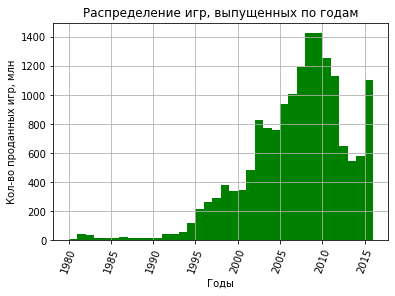

In [11]:
# Распределение игр, выпущенных по годам
data['year_of_release'].hist(bins = 36, color = 'g')

plt.xlabel('Годы')
plt.ylabel('Кол-во проданных игр, млн')
plt.title('Распределение игр, выпущенных по годам')
plt.xticks(rotation=70)
plt.show()


#### Вывод
- посмотрев на диаграмму, можно сделать вывод, что после 2002-го года происходит резкое увеличение продаж игр, более чем в 2 раза. 
- После гистограммы актуальный период кажется от 2002 до 2016 года.

In [12]:
# отберем 10 платформ
data_10 = data.pivot_table(index = 'platform', values = 'sum_sales', 
                           aggfunc = 'sum').sort_values(by = 'sum_sales', 
                                                        ascending=False).head(10).reset_index()


In [13]:
data_10

,platform,sum_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


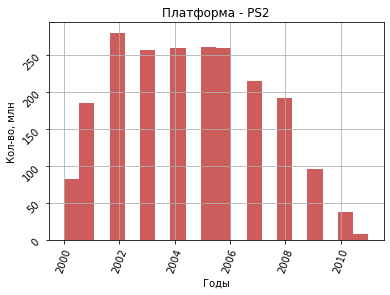

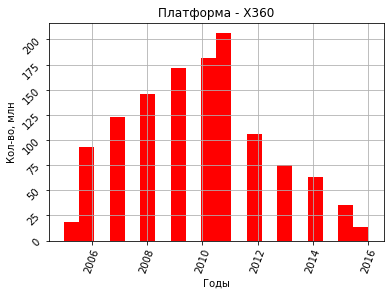

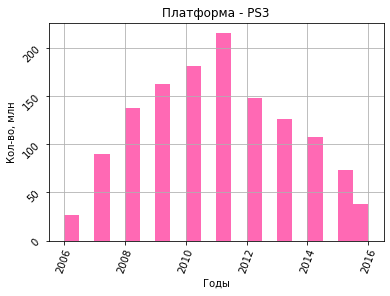

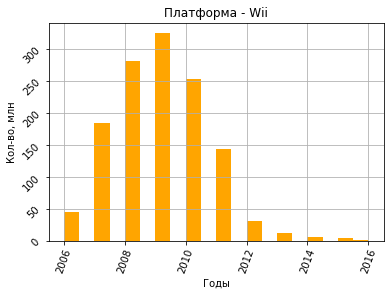

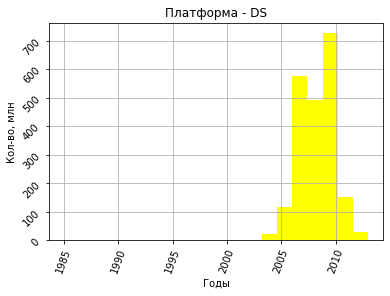

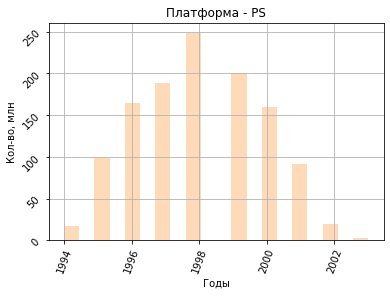

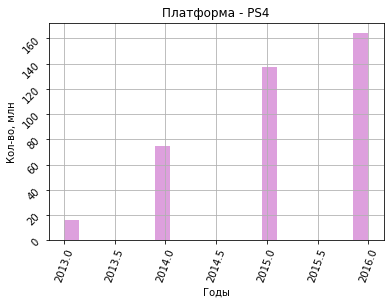

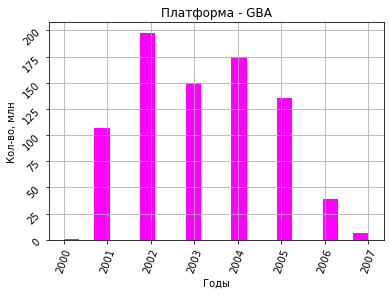

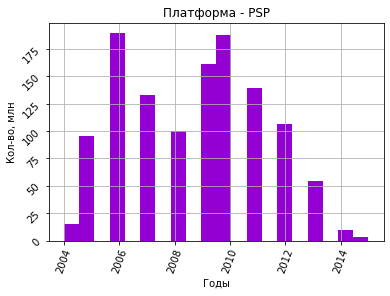

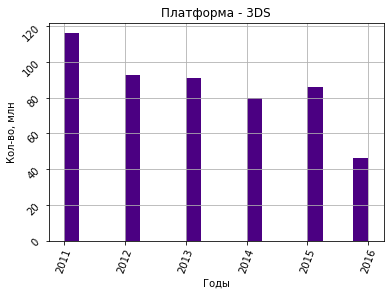

In [14]:
# посмотрим на распеределение по 10 платформам
color = ['#CD5C5C', '#FF0000', '#FF69B4', '#FFA500', '#FFFF00', 
         '#FFDAB9', '#DDA0DD', '#FF00FF', '#9400D3', '#4B0082']

def hh(data, col, row, col_2, c):
    plt.figure(figsize = (6, 4))
    data[data[col] == row][col_2].hist(bins = 20, color = c)
    
    plt.xlabel('Годы')
    plt.ylabel('Кол-во, млн')
    plt.title('Платформа - ' + row)
    plt.xticks(rotation=70)
    plt.tick_params(axis='y', labelrotation=45)
    
for i in range(10):
    hh(data, 'platform', data_10['platform'][i], 'year_of_release', color[i])    
    

#### Вывод
- отобрали 10 платформ с самыми большими суммарными продажами
- построили гистограммы распределения по годам для 10 платформ 
- можно заметить, что чаще всего платформы существуют 10 лет
- PS4 выпустили в 2013 г, поэтому продажи только набирают обороты
- 3DS выпущена в 2011, но продажи постепенно спадают


- думаю, что можно считать актуальный период с 2009 г., т к на гистограмме видно резкое увеличение продаж игр, также платформы актуальны не менее 10 лет, что близко к разнице между 2016 и 2009г.

In [15]:
# датафрейм на актуальный период
relevant_data = data.query('year_of_release >= 2009')

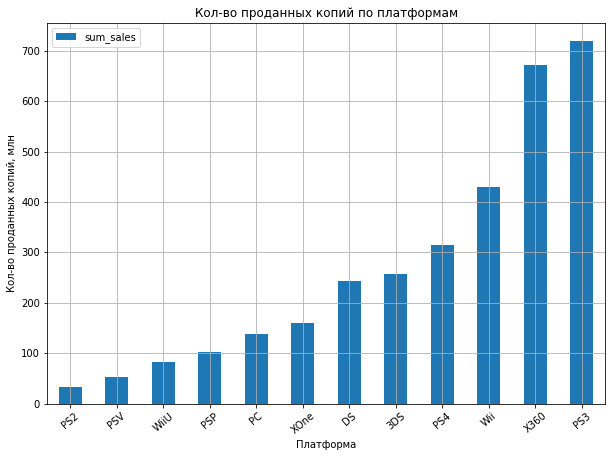

In [16]:
# найдем сколько млн копий продано по каждой платформе
sales_leader = relevant_data.pivot_table(index = 'platform', 
                                         values = 'sum_sales', 
                                         aggfunc = 'sum').sort_values(by = 'sum_sales')

sales_leader.plot(kind='bar', grid = True, figsize = (10, 7))

plt.title('Кол-во проданных копий по платформам')
plt.xlabel('Платформа')
plt.ylabel('Кол-во проданных копий, млн')
plt.xticks(rotation=40)
plt.show()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]), <a list of 12 Text yticklabel objects>)

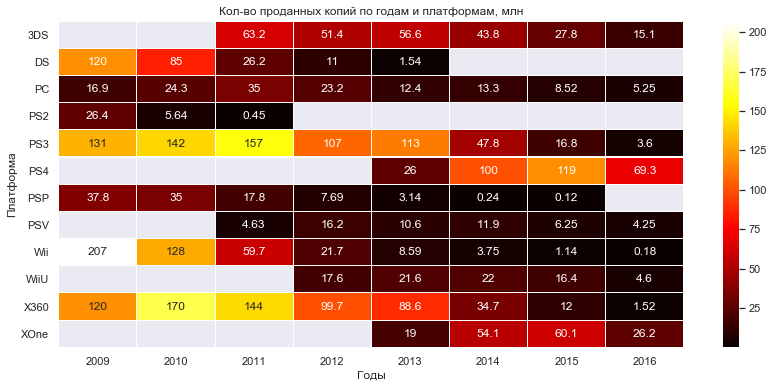

In [17]:
# распределение продаж игр по годам и платформам
sales_division = relevant_data.pivot_table(
                        index='platform', 
                        columns='year_of_release', 
                        values='sum_sales', 
                        aggfunc=sum)
sns.set(rc={'figure.figsize':(14, 6)})
sns.heatmap(sales_division, cmap= 'hot', linewidths=0.1, annot = True, fmt='.3g')
plt.title('Кол-во проданных копий по годам и платформам, млн')
plt.ylabel('Платформа')
plt.xlabel('Годы')
plt.yticks(rotation=0)

#### Вывод
- больше всего продано копий для платформ PS3, X360, Wii
- если посмотреть на график кол-ва проданных копий по годам и платформам видно, что вышеперечисленные платформы к 2016 г. уже либо исчезли из продажи, либо исчезают и имеют минимальные продажи игр
- платформы с наибольшим потенциалом это - PS4, вышедшая в 2013 г., XOne, вышедшая также в 2013 г.
- 3DS хоть и вышла в 2011г, но видно постоянное снижение проданных копий
- нельзя сбрасывать со счетов и PC, в годы выхода больших и долгожданных игр продажи достаточно большие, например 2010-2012 годы.

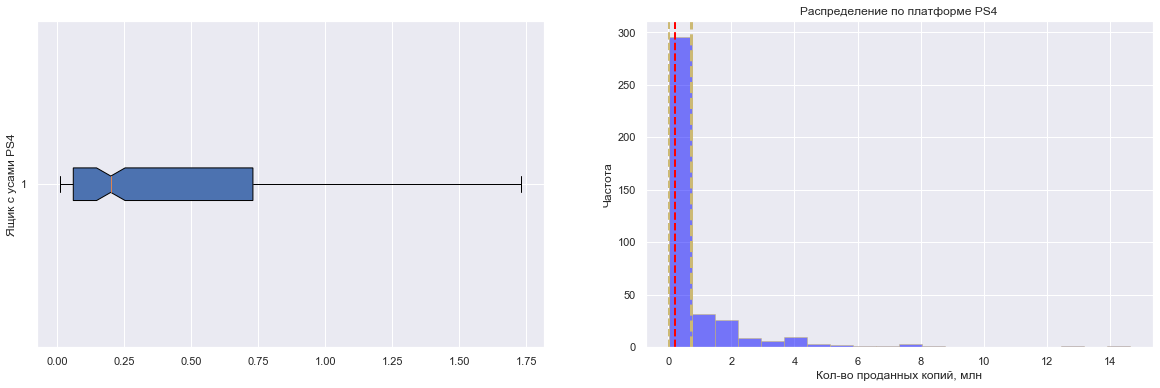

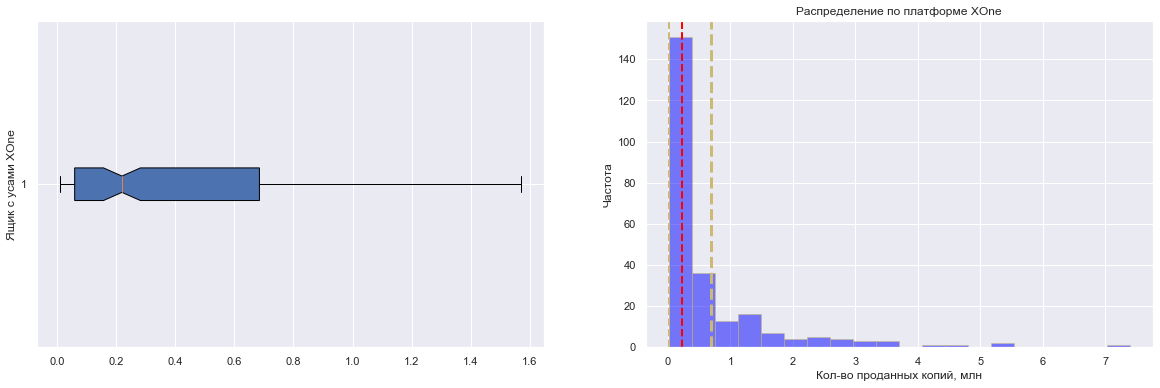

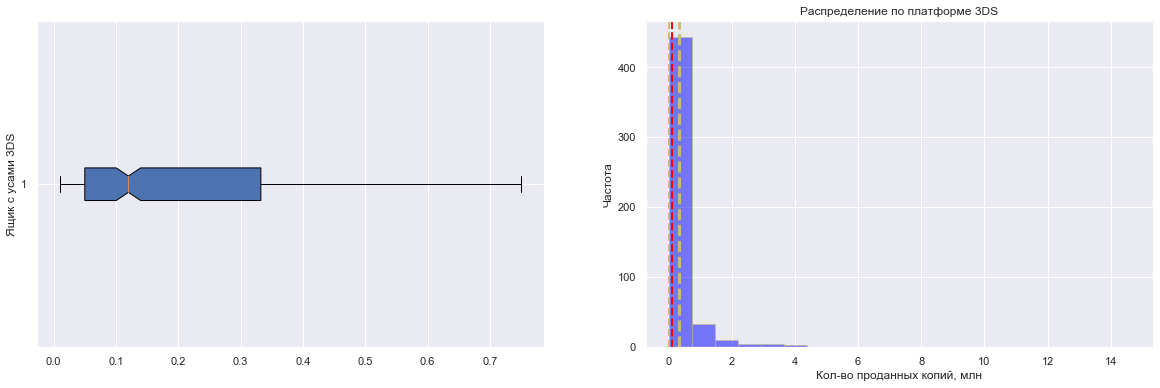

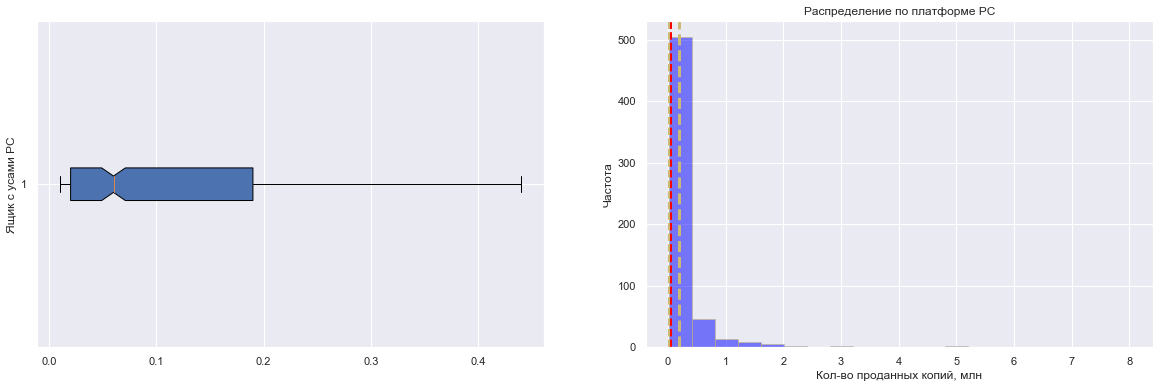

In [18]:
# построим ящик с усами и распределение по выбранным платформам
def my_hist(df, col, row, col_2):
    fig, axes = plt.subplots(nrows = 1, ncols = 2,  figsize=(20, 6))
    
    X_1 = df.loc[(df[col] == row), col_2]
    axes[0].boxplot(X_1,               
            notch=True,             
            sym="o",                
            vert=False,
            widths = 0.1, 
            patch_artist = True,
                showfliers = False)
    axes[0].set_ylabel('Ящик с усами ' + row)
    axes[0].grid(True)
    
    axes[1].hist(X_1,
                bins=20, 
                alpha=0.5, 
                ec='y',
                color='blue',
                )
    plt.axvline(x=X_1.median(),
                linewidth=2, 
                color='red', 
                linestyle='--')
    plt.axvline(x=X_1.quantile(0.01),
                linewidth=2, 
                color='y', 
                linestyle='--')
    plt.axvline(x=X_1.quantile(0.75),
                linewidth=3, 
                color='y', 
                linestyle='--')
    axes[1].set_title('Распределение по платформе ' + row)
    axes[1].set_xlabel('Кол-во проданных копий, млн')
    axes[1].set_ylabel('Частота')
    axes[1].grid(True)
    
    #plt.subplots_adjust(wspace=0.3, hspace=0.6) # задаем отступы
    plt.show()
    
    
    
for i in ['PS4', 'XOne', '3DS', 'PC']:
    my_hist(relevant_data, 'platform', i, 'sum_sales') 

#### Вывод
- построим ящик с усами и распределение по выбранным платформам - 'PS4', 'XOne', '3DS', 'PC'
- на всех платформах видно, что чаще всего игры продаются маленькими тиражами
- 75% игр имеет продажи менее 1млн копий, на РС и 3DS меньше 0,35 млн

#### Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
- Выберем PS4, как наиболее перспективную

In [19]:
data_PS4 = relevant_data.loc[(relevant_data['platform'] == 'PS4')]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Слабая взаимосвязь 0.41, между sum_sales и critic_score.


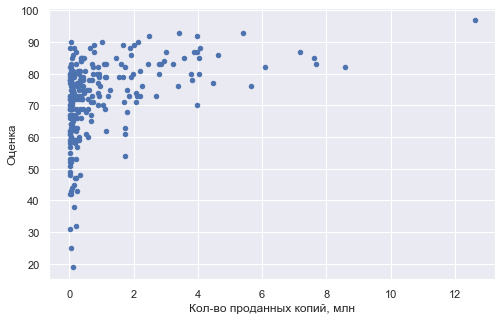

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Очень слабая взаимосвязь -0.03, между sum_sales и user_score.


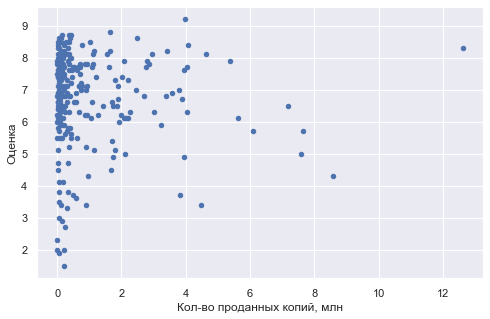

In [20]:
def corr_price(dt, col_1, col_2):
    cor = dt[col_1].corr(dt[col_2])
    
    if abs(cor) <= 0.2:
        print('Очень слабая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    elif abs(cor) <= 0.5:
        print('Слабая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    elif abs(cor) <= 0.7:
        print('Средняя взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    elif abs(cor) <= 0.9:
        print('Высокая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    elif abs(cor) > 0.9:
        print('Очень высокая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), col_1, col_2))
    dt.plot(x=col_1, y=col_2, kind='scatter', grid = True, figsize =(8, 5)) 
    plt.xlabel('Кол-во проданных копий, млн')
    plt.ylabel('Оценка')
    plt.show()

corr_price(data_PS4, 'sum_sales', 'critic_score')
corr_price(data_PS4, 'sum_sales', 'user_score')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 <a list of 9 Text xticklabel objects>)

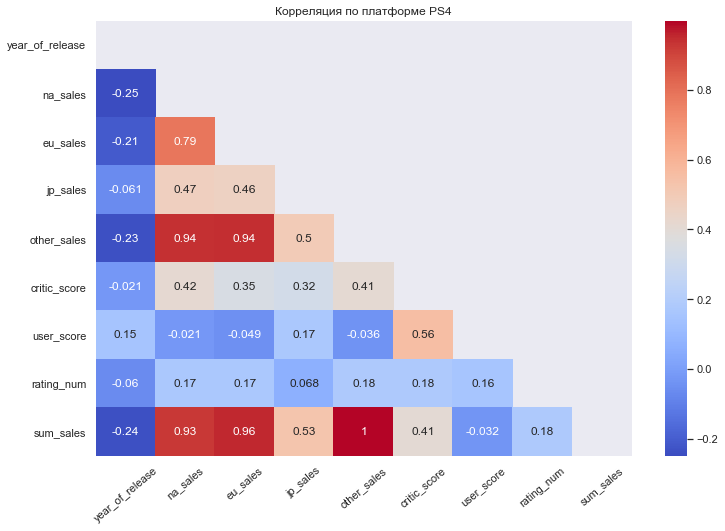

In [21]:
matrix = np.triu(data_PS4.corr())
sns.set(rc={'figure.figsize':(12, 8)})
sns.heatmap(data_PS4.corr(), annot = True, fmt='.2g', cmap= 'coolwarm', mask=matrix)
plt.title('Корреляция по платформе PS4')
plt.xticks(rotation=40)

#### Вывод
- посмотрев на корреляцию можно сделать вывод, что взаимосвязь между продажами и критикой специалистов слабая - 0.41
- корреляция между продажами и оценкой пользователей очень слабая и отрицательная - (-0.03).
- на продажи игр слабо влияет мнение и оценки специалистов и никак не влияет мнение пользователей.
- это можно объяснить тем, что большинство препочитает покупать игры на стадии её выхода, т е это предзаказы или покупка в первые дни, поэтому оценки пользователей, появляющиеся гораздо позже, и не учитываются.

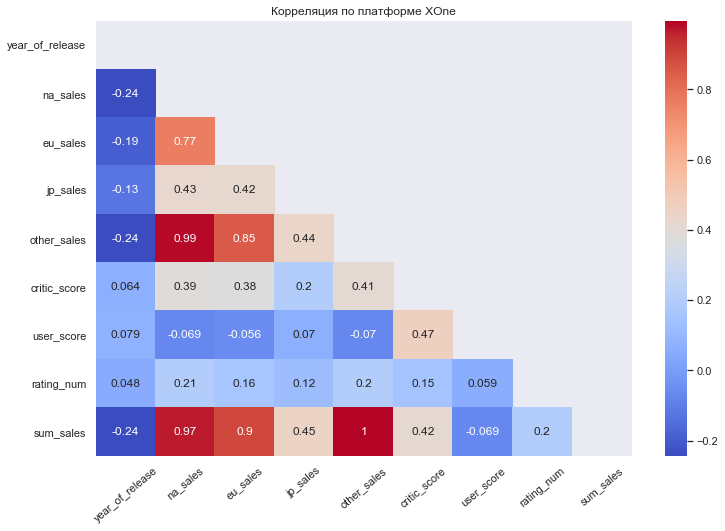

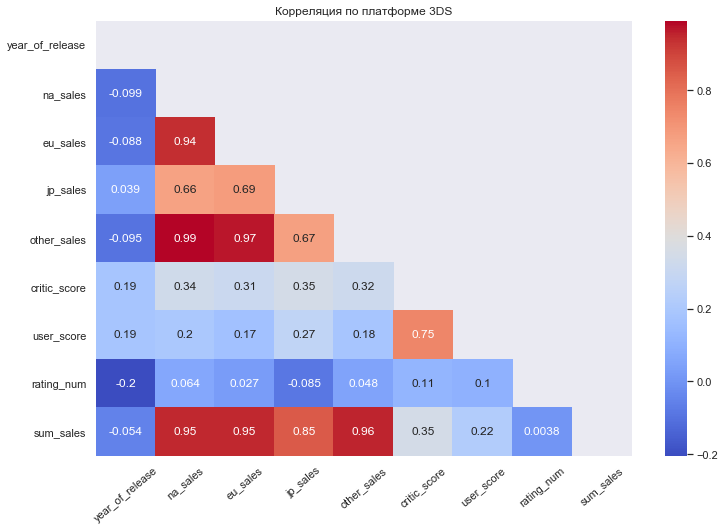

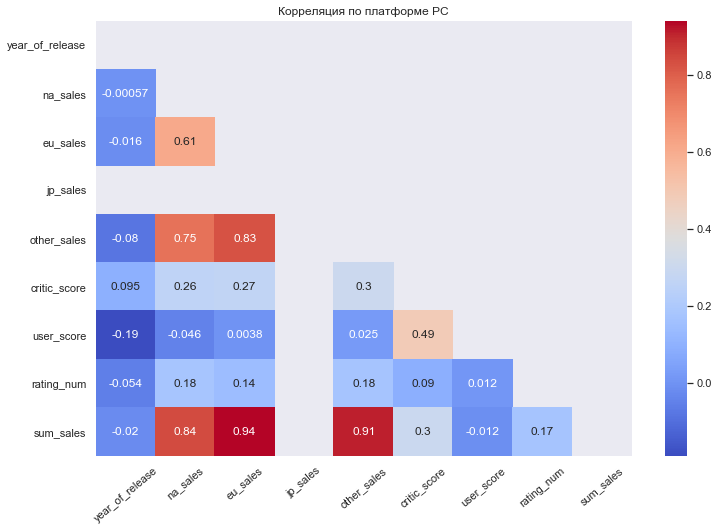

In [22]:
# проверем и на других платформах
def gg(row):
    dt = relevant_data.loc[(relevant_data['platform'] == row)]
    sns.set(rc={'figure.figsize':(12, 8)})
    matrix = np.triu(dt.corr())
    sns.heatmap(dt.corr(), annot = True, fmt='.2g', cmap= 'coolwarm', mask=matrix)
    plt.title('Корреляция по платформе ' + row)
    plt.xticks(rotation=40)
    plt.show()
    
    
for i in ['XOne', '3DS', 'PC']:
    gg(i) 

#### Вывод
- корреляция по продажам и оценкам критиков находится в промежутке 0,25-0,42, продажи достаточно слабо зависят от оценка специалистов
- корреляция по продажам и оценкам пользователей находится в промежутке -0,032 -0,22, на продажи почти не влияет оценка пользователей. Только у 3DS оценки пользователей (0,22) немного влияют на продажи.

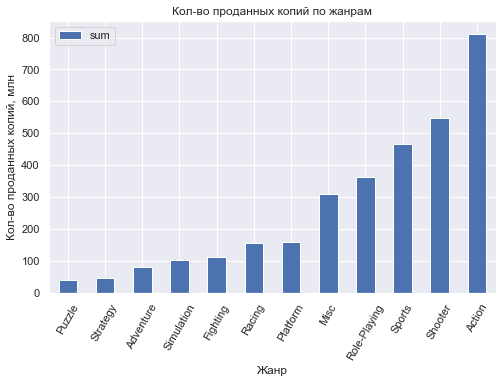

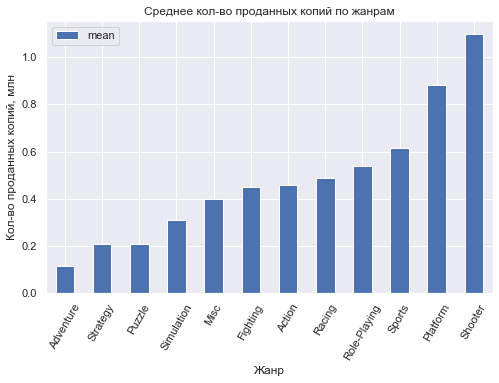

In [23]:
# найдем продажи по жанрам
genre_leader = relevant_data.pivot_table(index = 'genre', 
                                         values = 'sum_sales', 
                                         aggfunc = ['sum', 'mean'])

genre_leader.columns = ['sum', 'mean']


genre_leader.sort_values(by = 'sum').plot(kind='bar', y = 'sum', grid = True, figsize = (8, 5))
plt.title('Кол-во проданных копий по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Кол-во проданных копий, млн')
plt.xticks(rotation=60)
plt.show()

genre_leader.sort_values(by = 'mean').plot(kind='bar', y = 'mean', grid = True, figsize = (8, 5))
plt.title('Среднее кол-во проданных копий по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Кол-во проданных копий, млн')
plt.xticks(rotation=60)
plt.show()

#### Вывод
- с большим отрывом лидирует жанр Action, далее идут Sports и Shooter, наверное это можно объяснить тем, что большинство пользователей хотят от игр получить заряд адреналина и экшена, что и обеспечивают жанры с активным сюжетом
- меньше всего копий продано в Strategy и Puzzle - эти жанры больше располагают к медленной, вдумчивой игре и далеко не всем это подходит, что и отражено в кол-ве проданных копий
- а по средним продажам в лидерах появляются жанры - Platform и RPG - за счет Японского рынка

###  Составим портрет пользователя каждого региона

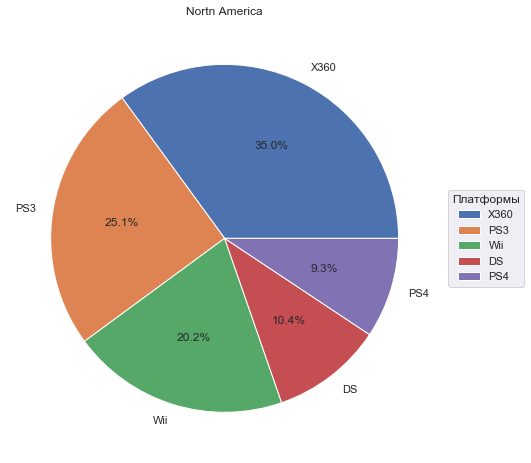

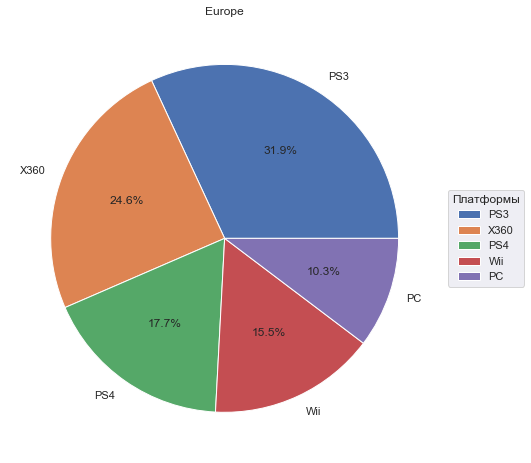

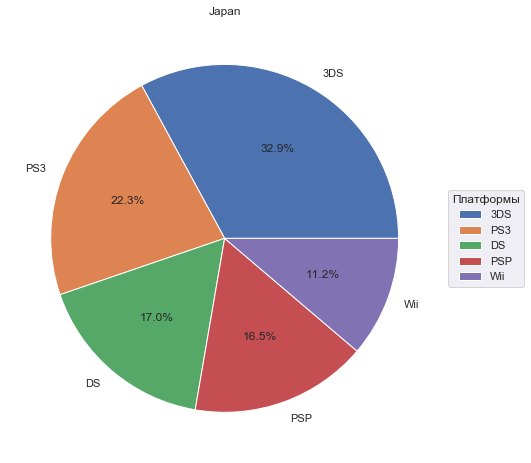

In [24]:
def region_sales(row):
    sales = relevant_data.pivot_table(index = 'platform',                                         
                                          values = row, 
                                          aggfunc = 'sum').sort_values(by = row, ascending = False).head(5)
    if row == 'na_sales':
        plt.title('Nortn America')
    elif row == 'eu_sales':
        plt.title('Europe')
    else:
        plt.title('Japan')
          
    plt.pie(sales, autopct = '%1.1f%%', labels = sales.index.to_list())
    plt.legend(title = 'Платформы',
          loc = 'center left',
          bbox_to_anchor = (1, 0, 0.5, 1))
    plt.show()
    
    
for i in ['na_sales', 'eu_sales', 'jp_sales']:
    region_sales(i)

#### Вывод
- в Европе и Сев.Ам. в топ-5 входят 4 одинаковые платформы, но иначе расположеннные в топе
- если в Сев.Ам.  лидируют X360 и PS3, то в Европе наоборот
- в Японии в топ-4 исключительно платформы японских компаний Sony и Nintendo, возможно DS очень удачная модель подкрепленная хорошими рекламными и маркетинговыми действиями

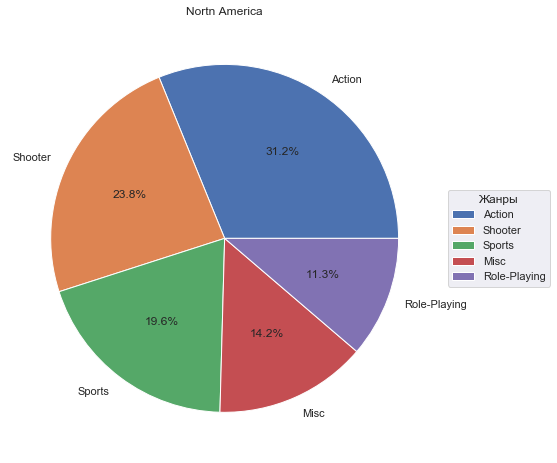

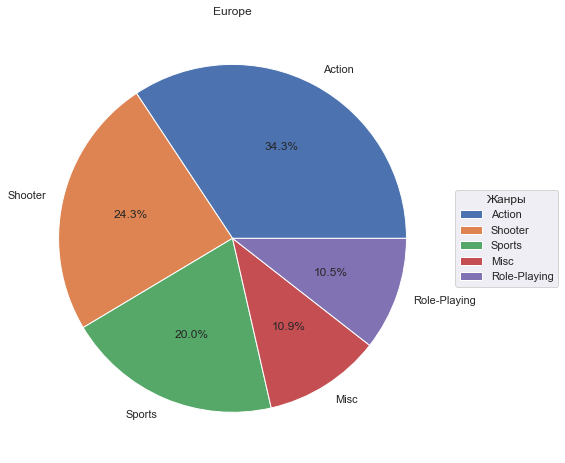

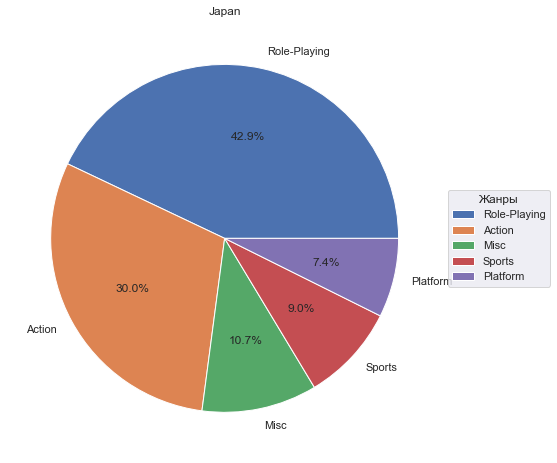

In [25]:
def region_genre(row):
    genre = relevant_data.pivot_table(index = 'genre',                                         
                                          values = row, 
                                          aggfunc = 'sum').sort_values(by = row, ascending = False).head(5)
    if row == 'na_sales':
        plt.title('Nortn America')
    elif row == 'eu_sales':
        plt.title('Europe')
    else:
        plt.title('Japan')
          
    plt.pie(genre, autopct = '%1.1f%%', labels = genre.index.to_list())
    plt.legend(title = 'Жанры',
          loc = 'center left',
          bbox_to_anchor = (1, 0, 0.5, 1))
    plt.show()
    
    
for i in ['na_sales', 'eu_sales', 'jp_sales']:
    region_genre(i)

#### Вывод
- в Сев.Ам. и Европе топ-5 жанров совпадает и процентые соотношения очень близки(примерно до 1% различия)
- в Японии доля жанра RPG достаточно большая, более 42%, и у Action - 30%, остальные жанры заметно отстают. 
- В Японии сложились свои традиции и свои правила, которые и влияют на выбор платформ и игровых жанров, что и показывают графики.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Очень слабая взаимосвязь 0.19, между na_sales и rating_num.


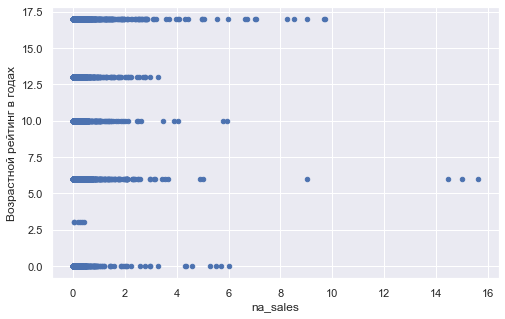

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Очень слабая взаимосвязь 0.17, между eu_sales и rating_num.


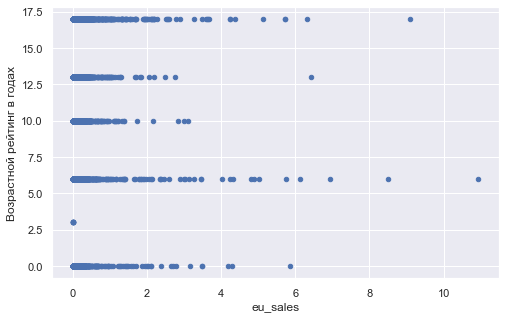

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Очень слабая взаимосвязь -0.06, между jp_sales и rating_num.


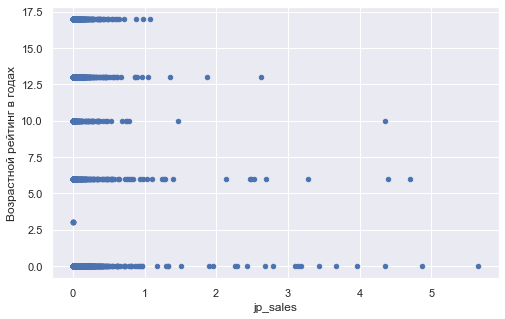

In [26]:
def corr_esrb(row):
    cor = relevant_data[row].corr(relevant_data['rating_num'])
    
    if abs(cor) <= 0.2:
        print('Очень слабая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), row, 'rating_num'))
    elif abs(cor) <= 0.5:
        print('Слабая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), row, 'rating_num'))
    elif abs(cor) <= 0.7:
        print('Средняя взаимосвязь {}, между {} и {}.'.format(round(cor, 2), row, 'rating_num'))
    elif abs(cor) <= 0.9:
        print('Высокая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), row, 'rating_num'))
    elif abs(cor) > 0.9:
        print('Очень высокая взаимосвязь {}, между {} и {}.'.format(round(cor, 2), row, 'rating_num'))
    relevant_data.plot(x=row, y='rating_num', kind='scatter', grid = True, figsize =(8, 5)) 
    plt.ylabel('Возрастной рейтинг в годах')
    plt.show()

for i in ['na_sales', 'eu_sales', 'jp_sales']:
    corr_esrb(i)

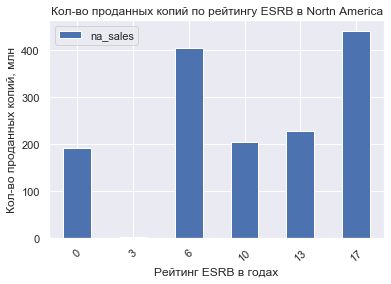

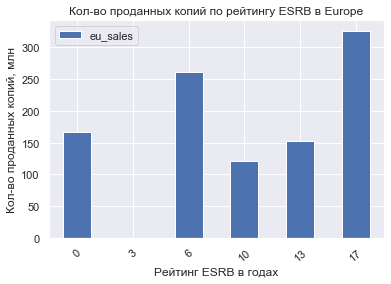

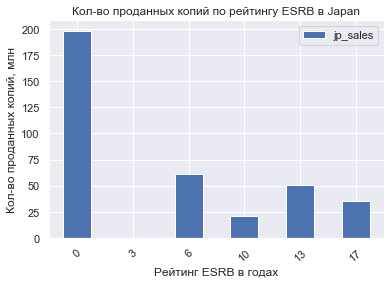

In [27]:
def esrb(row):
    genreff = relevant_data.pivot_table(index = 'rating_num', 
                                    values = row, 
                                    aggfunc = 'sum')

    
    genreff.plot(kind='bar', grid = True, figsize = (6, 4))
    if row == 'na_sales':
        plt.title('Кол-во проданных копий по рейтингу ESRB в Nortn America')
    elif row == 'eu_sales':
        plt.title('Кол-во проданных копий по рейтингу ESRB в Europe')
    else:
        plt.title('Кол-во проданных копий по рейтингу ESRB в Japan')
    
    plt.xlabel('Рейтинг ESRB в годах')
    plt.ylabel('Кол-во проданных копий, млн')
    plt.xticks(rotation=40)
    plt.show()

for i in ['na_sales', 'eu_sales', 'jp_sales']:
    esrb(i)

#### Вывод
- возрастной рейтинг слабо зависит от продаж, т е с увеличение возрастного ценза продажи слабо увеличиваются
- больше всего продается игры с рейтингом  
    - «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет
    - «E» («Everyone») — «Для всех от 6 лет»: Содержание вполне подходит для возрастной категории от 6 лет и старше, такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера.

###  Проверка гипотез

In [28]:
# проверка дисперсии
user_xbox = relevant_data [relevant_data ['platform'] == 'XOne']['user_score'].dropna()
user_pc = relevant_data [relevant_data ['platform'] == 'PC']['user_score'].dropna()

def var_pr(df1, df2):
    x = round(df1.var() / df2.var() * 100)
    if x >= 5:
        return False
    else:
        return True
    
disp = var_pr(user_xbox, user_pc)


- проверим гипотезы, Но - ср. пользовательский рейтинг платформы XOne равен ср. пол рейтингу платформы PC, альтернативная гипотеза тогда следующая - ср. пол. рейтинг платформы XOne не равен ср. пол рейтингу платформы PC

In [29]:
alpha = 0.05

result_1 = st.ttest_ind(user_xbox, user_pc, equal_var = disp)

print('p - значение', result_1.pvalue)

if result_1.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p - значение 0.29856178733970584
Не получилось отвергнуть нулевую гипотезу


#### Вывод
- гипотеза проверена и её нельзя отвергнуть - ср. пол. рейтинг платформы XOne может быть равен ср. пол рейтингу платформы PC

In [30]:
# проверка дисперсии
user_action = relevant_data [relevant_data ['genre'] == 'Action']['user_score'].dropna()
user_sports = relevant_data [relevant_data ['genre'] == 'Sports']['user_score'].dropna()

def var_pr(df1, df2):
    x = round(df1.var() / df2.var() * 100)
    if x >= 5:
        return False
    else:
        return True
    
disp_genre = var_pr(user_action, user_sports)


- проверим гипотезы, Но - ср. пользовательский рейтинг жанра Action равен ср. пол рейтингу жанра Sports, альтернативная гипотеза тогда следующая - ср. пол. рейтинг жанра Action не равен ср. пол рейтингу жанра Sports

In [31]:
alpha = 0.05

result_2 = st.ttest_ind(user_action, user_sports, equal_var = disp_genre)

print('p - значение', result_2.pvalue)

if result_2.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p - значение 3.493323839142059e-13
Отвергаем гипотезу


#### Вывод
- гипотеза проверена и ее можно отвергнуть - ср. пол. рейтинг жанра Action не равен ср. пол рейтингу жанра Sports

# Вывод

- платформы обычно актуальны в течении 10 лет, потом их заменяет новая модифицированная платформа 
- в Европе и Сев. Ам. наиболее популярные плафтормы и жанры игр совпадают, а вот в Японии своя игровая культура, что сказывается и на предпочтении пользователей, популярны несколько другие платформы и особое различие по жанрах.
- продажи слабо зависят от оценок специалистов, и почти не зависят от оценок пользователей и возрастного рейтинга ESRB
- самые продаваемые жанры - Action, Sports и Shooter. Это жанры с активным сюжетом, что является наиболее привлекательно для покупателей
- по платформам наиболее перспективны следующие:
   - PS4 с самыми большими продажами и самая молодая платформа(4 года), исходя из продаж своих предшественников (PS2, PS3) продажи должны быть высокими еще как минимум 4 года. После чего будет спад, на фоне слухов о выходе новой модификации PS.
   - 3DS платформа с хорошими продажами, в основном за счет Японского рынка. Возраст - 6 лет.
   - XOne продажи росли до 2015 места, но т к за 2016 год данные не полные, то нельзя однозначно сказать выросли или нет  продажи, но в 2015 г продажи были на втором месте среди всех платформ. 
- рекомендации по рекламе в разных регионах:
   - для сев.Ам. 
        1. XOne, т.к самая популярная в этом регионе X360 уже почти не продается, а XOne это новая модификация
        2. PS4, т.к популярная в этом регионе PS3 уже не продается, а PS4 это новая модификация
        3. WiiU, которая является модифицированной версией Wii, которая на 2 месте в данном регионе, а WiiU это новая модификация
        - по жанрам это Action, Shooter и Sports
   - для Европы
        1. PS4, т.к самые популярные в этом регионе PS3 уже не продаются
        2. XOne, т.к популярная в этом регионе X360 уже почти не продается
        3. WiiU, которая является модифицированной версией Wii
        - по жанрам это Action, Shooter и Sports
   - для Японии
        1. 3DS т.к она самая популярная в этом регионе 
        2. PS4, т.к популярная в этом регионе PS3 уже не продается
        - по жанрам это RPG и Action
        